# BBC - Projet
## Diagnostic miARN pour détecter le cancer de la prostate

- Professeur: Carlos Peña (<a href="mailto:carlos.pena@heig-vd.ch">carlos.pena@heig-vd.ch</a>)
- Assistante: Aitana Lebrand (<a href="mailto:aitana.nevesdasilva@heig-vd.ch">aitana.nevesdasilva@heig-vd.ch</a>)
- Etudiant: Jan Purro (<a href="mailto:jan.purro@heig-vd.ch">jan.purro@heig-vd.ch</a>)
- Etudiant: Thibault Schowing (<a href="mailto:thibault.schowing@heig-vd.ch">thibault.schowing@heig-vd.ch</a>)

Date: Printemps 2016

Note: Ce projet est largement inspiré du laboratoire 3-4 de BBC-2016

## Objectifs pédagogiques

L'objectif de ce projet est de mettre en application les notions biologiques et informatiques apprises en cours de semestre.  


## But du projet

Le but du projet est d'analyser des données micro-arrays sur la concentration de micro-ARN dans l'urine de personnes atteintes ou non du cancer de la prostate (résumé PCa dans ce document) afin de pouvoir créer un modèle pour déterminer, à partir d'un nouvel échantillon, si la personne concernée est atteinte de PCa ou non avec un minimum de miARN afin de réduire les coûts du test. 


## Démarche

Dans une première partie, les données seront mises en forme afin de pouvoir être traitées. En suite, par plusieurs méthodes comme la corrélation de Pearson ou le t-test, les gènes ayant une relation entre patients atteints ou non de PCa seront extraits du lot des différents gènes. 

Une fois ces gènes extraits, un modèle d'apprentissage sera entrainé avec un *train set* puis il sera validé avec un *test set*. 


## Rapport de labo



On lit les données depuis le fichier `GSE45604_series_matrix.txt`. Le fichier contenant nombre d'informations pas forcément utiles pour notre travail, nous isolons les données qui nous intéresse.

In [1]:
import os
import numpy as np
import pylab as plt
import pandas as pd
import numpy as np
from Bio import Geo
%matplotlib inline 

# Fonctionne pour les fichiers .soft
def load_geo(myfile):
    handle = open(myfile)
    records = Geo.parse(handle)
    return records

# Les différents records, le soft n'es pas forcément utile.

#records_soft = load_geo('../data/GSE45604_family.soft')
records_matrix = open('../data/GSE45604_series_matrix.txt')

# Données brutes (uniquement les lignes avec condition et miARN)
matrice =  [l.split('\t') for l in records_matrix.readlines()[67:-1]]
records_matrix.seek(0)
conditions = records_matrix.readlines()[34].split('\t')


# matrice <list> -> <ndarray>
matrice = np.array(matrice)
conditions = np.array(conditions[1:])

# On a 2 types de cellules: prostate normale ou cancéreuse qu'on va marquer PCa ou Normal
idx_normal = []
idx_pca = []
i = 1
for c in conditions:
    if c.startswith('"PCa'):
        matrice[0,i] = 'PCa'
        idx_pca.append(i)
    else:
        matrice[0,i] = 'Normal'
        idx_normal.append(i)
    i += 1

# TODO: mettre dans l'ordre Normale puis PCa
idx_ordered = [0] + idx_normal + idx_pca
print("idx: ")
print(idx_ordered)      

# AVANT TRANSPOSITION
# Matrice[0] contient ID_REF - PCa - PCa - ... - Normal - PCa - ...
# Matrice[1] contient 234342_st - 23.3 - 342.3 - ...
# Matrice[:,0] contient ID_REF suivi de tous les id de gènes
# Matrice[:,1...n] Contient PCa ou normal suivi de toutes les mesures pour ce prélèvement sur un patient atteint ou non
print matrice

# On réordonne avec les Idx dans le bon ordre
matrice = matrice[:,idx_ordered]

idx: 
[0, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[['"ID_REF"' 'PCa' 'PCa' ..., 'PCa' 'PCa' 'PCa']
 ['"1367452_st"' '10.93488' '13.60777' ..., '16.10932' '14.50111'
  '15.29177\n']
 ['"1367453_st"' '14.42092' '15.43682' ..., '15.15539' '17.9957'
  '25.17342\n']
 ..., 
 ['"zma-miR529_st"' '15.90142' '20.75771' ..., '12.53141' '13.16191'
  '13.03476\n']
 ['"zma-miR827-star_st"' '14.19222' '17.82426' ..., '14.37837' '16.76542'
  '16.02319\n']
 ['"zma-miR827_st"' '15.00203' '13.44333' ..., '14.51185' '11.54497'
  '13.00997\n']]


On sépare le dataset en deux sous-ensembles :

- Test: Données qui ne seront pas prise en compte pour créer le model mais uniquement pour le valider.


- Train: Données (plus nombreuses que le test set) qui seront utilisée pour entrainer le modèle. 


In [2]:
# Diviser le dataset en deux -> test et train


print matrice[0,:]

#print(np.shape(matrice)) # (20644,61)

# idx sélectionnés au hasard pour servir de test afin de valider le modèle en fin de projet
idx_test = [5,9,19,28,32,48,60]

# Le reste des idx va servire à extraire les données importantes et entrainer le modèle. 
idx_train = range(0,len(matrice[0]))
[idx_train.remove(i) for i in idx_test]
#idx_train.remove(0)

idx_test = [0,5,9,19,28,32,48,60]

print("IDX test: ", idx_test)
print("IDX train: ", idx_train)

data = matrice

data_test = data[:,idx_test]
#data_test = data_test[0]
data = data[:,idx_train]

print("Data Test", data_test)
print("Data Train", data)


['"ID_REF"' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa'
 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa'
 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa'
 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa'
 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa']
('IDX test: ', [0, 5, 9, 19, 28, 32, 48, 60])
('IDX train: ', [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
('Data Test', array([['"ID_REF"', 'Normal', 'Normal', ..., 'PCa', 'PCa', 'PCa'],
       ['"1367452_st"', '11.47406', '13.86868', ..., '11.64925',
        '14.36717', '15.29177\n'],
       ['"1367453_st"', '14.39909', '16.66849', ..., '15.40274', '21.7944',
        '25.17342\n'],
       ..., 
       ['"zma-miR529_st"', 

Pour identifier les gènes exprimés différemment chez les patients cancéreux des patients normaux, nous allons comparer l'expression de chaque gène par rapport à un profile désiré. On cherche un profil où l'expression d'un gène est significativement différente entre un patient sain et un patient cancéreux.

[['"ID_REF"' 'Normal' 'Normal' ..., 'PCa' 'PCa' 'PCa']
 ['"1367452_st"' '17.73092' '13.50618' ..., '17.9872' '16.10932' '14.50111']
 ['"1367453_st"' '15.98614' '17.80959' ..., '19.47316' '15.15539' '17.9957']
 ..., 
 ['"zma-miR529_st"' '18.99103' '13.52609' ..., '13.46852' '12.53141'
  '13.16191']
 ['"zma-miR827-star_st"' '15.40228' '14.92211' ..., '15.38391' '14.37837'
  '16.76542']
 ['"zma-miR827_st"' '17.98331' '17.41605' ..., '10.7645' '14.51185'
  '11.54497']]
desired_profile = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


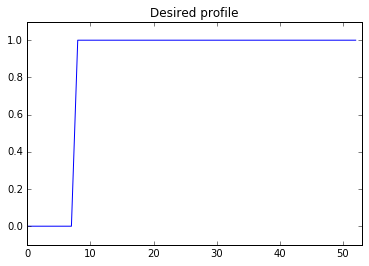

In [3]:

print(data)

desired_profile = [1 if s =='PCa' else 0 for s in data[0,1:]]
desired_profile_test = [1 if s =='PCa' else 0 for s in data_test[0,1:]]
print('desired_profile = '+str(desired_profile))


# Représentation graphique de Desired Profile:

fig = plt.figure()

plt.plot(desired_profile)
plt.ylim([-0.1,1.1])
plt.xlim([0,len(desired_profile)])
plt.title('Desired profile')
plt.show()


Ci-dessous, nous allons chercher la corrélation de pearson, entre l'expression des gènes individuels et le profil désiré. Plus une valeur est proche de 1, plus la corrélation est forte, une valeur négative indiquant une corrélation inverse (ce qui nous intéresse aussi, bien évidemment). Une valeur proche de 0 indique une absence de corrélation.

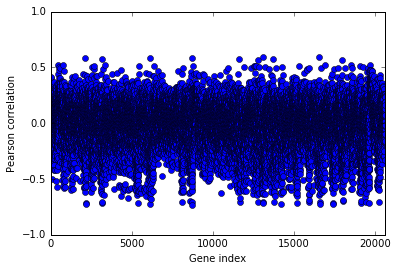

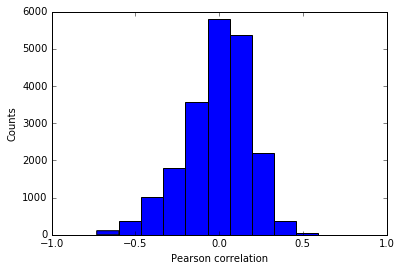

In [4]:
# Correlation
#print(len(desired_profile))
#print(len(data[0]))

def pearson_genes(data,desired_profile,show_plot=1):

    import scipy.stats as ss

    
    correl = [] # contains the correlation for each gene
    correl_p  = [] # for now, do not try to understand what correl_p is...
    
    # loop over genes
    for i in range(np.shape(data)[0]-1): # do not consider first line of data (=header)
        
        gene_expression = data[i+1,1:] # do not consider first  column (= gene identifiers)
        gene_expression = np.array(gene_expression,dtype=float) # convert to float
        
        pearson_corr = ss.pearsonr(gene_expression,desired_profile) # calculate Pearson correlation
        correl.append(pearson_corr[0])
        correl_p.append(pearson_corr[1]) # forget about this for now...
        
    correl = np.array(correl,dtype=float) # convert to array... easier to manipulate
    
    # plot correlation values
    if show_plot:
        fig = plt.figure()
        plt.plot(correl,'bo')
        plt.ylim([-1,1])
        plt.xlim([0,len(correl)])
        plt.xlabel('Gene index')
        plt.ylabel('Pearson correlation')
        plt.show()
        
        plt.figure()
        plt.hist(correl)
        plt.xlabel('Pearson correlation')
        plt.ylabel('Counts')
        plt.xlim([-1,1])
        plt.show()

    return (correl,correl_p)

co = pearson_genes(data,desired_profile)
corr = co[0]

Nous constatons que, malheureusement, il y a peu de gènes qui soient fortement corrélés ou inversemment corrélés. On peut tout de même noté que quelques gènes s'approchent d'une corrélation de -0.5, qui pourraient éventuellement être utilisé.

Afin de vérifier que les gènes corrélés ne sont pas simplement le fruit du hasard, nous allons maintenant randomiser les données, afin de comparer la corrélation de l'expression des gènes aléatoires avec celle du set de données.

In [5]:
def shuffle_data(data):
    
    from random import shuffle
    
    # get shuffled columns indexes
    shuffled_idx = range(1,np.shape(data)[1]) # ! do not shuffle the first colum (= gene identifiers)
    shuffle(shuffled_idx) # shuffled_idx is now shuffled
    #print (shuffled_idx)
    shuffled_idx.insert(0,0)

    # use shuffled_idx to randomize the columns of data
    data_random = data[:,shuffled_idx]
    data_random[0,:] = data[0,:] # put label conditons on top again

    return data_random
    
data_random = shuffle_data(data)


('Correlation: ', array([ 0.15356802,  0.01403211, -0.19437263, ...,  0.16407174,
       -0.15736331, -0.33065713]))
('Correl rand: ', array([ 0.0177155 ,  0.40123704,  0.04278028, ...,  0.14198351,
        0.15309606,  0.09471923]))


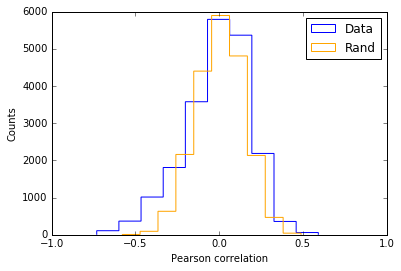

In [6]:
co = pearson_genes(data,desired_profile,0)
corr = co[0]
co_rand = pearson_genes(data_random, desired_profile,0)
corr_rand = co_rand[0]

# plot correlation values
print("Correlation: ", corr)
print("Correl rand: ", corr_rand)


plt.figure()
#plt.hist([corr, corr_rand], histtype='step', stacked=True, color=['Blue', 'Orange'], label=['Data', 'Rand'])
plt.hist(corr, histtype='step', stacked=True, color=['Blue'], label=['Data'])
plt.hist(corr_rand, histtype='step', stacked=True, color=['Orange'], label=['Rand'])
plt.xlabel('Pearson correlation')
plt.ylabel('Counts')
plt.xlim([-1,1])
plt.legend()

plt.show()

On peut constater que les données aléatoires sont moins corrélées ques les données originales. 

Toutefois, afin de confirmer que c'est bien le cas, il s'agit de randomiser plusieurs fois le set de données et de faire la moyenne de ses randomisations et de les comparer avec le set de base.

In [7]:
# Randomisation plusieurs fois, si déjà fait -> prendre fichier
N_genes = np.shape(data)[0]-1 #Nombre de gènes
N_random = 200
corr_random = np.empty((N_genes,N_random),dtype=float) 

def randomize_data(): 
    
    print(np.shape(corr_random))

    #Votre code...
    print("Loading...")
    for i in range(0, N_random ):
        data_rand = shuffle_data(data)
        correlation = pearson_genes(data_rand, desired_profile,0)
        patate = correlation[0]
        print("Pass "+ str(i+1)+ "/"+ str(N_random))
        corr_random[:,i] = patate

    print("\nDone !! \nCorr_random: ")
    print(corr_random)

    np.save('corr_randomized.npy', corr_random)
    
#Data randomized in corr_randomized.npy file
#randomize_data()
corr_random = np.load('corr_randomized.npy')
print(corr_random)

[[ 0.06331227 -0.12828498 -0.10523402 ...,  0.04355152  0.04198729
  -0.18096078]
 [ 0.28242425  0.06583799 -0.05111129 ...,  0.06539607  0.02244321
   0.12766586]
 [ 0.01293241 -0.22428414  0.29436062 ...,  0.09902635 -0.09873914
   0.09632078]
 ..., 
 [ 0.05103821 -0.08228534 -0.16243423 ..., -0.18522148  0.13617141
  -0.14877725]
 [-0.00046554 -0.01455795 -0.21492407 ..., -0.06051155 -0.20406963
   0.00967727]
 [-0.03853047  0.00174171 -0.15139051 ...,  0.06105523  0.2346925
   0.01434063]]


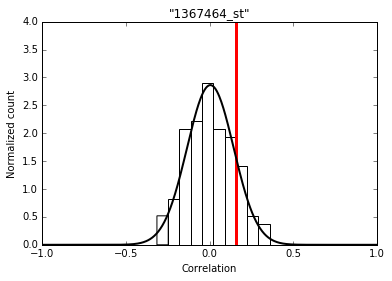

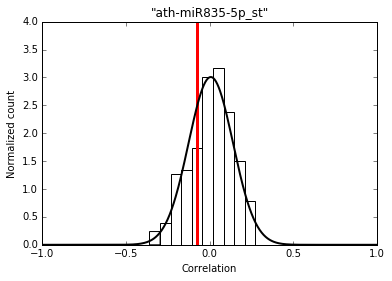

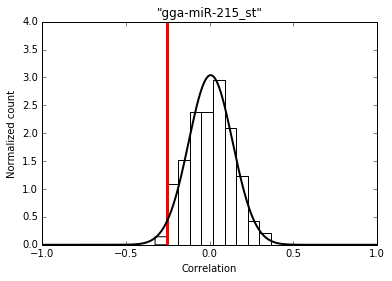

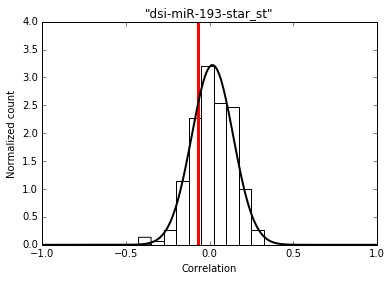

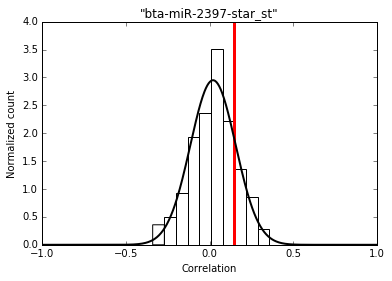

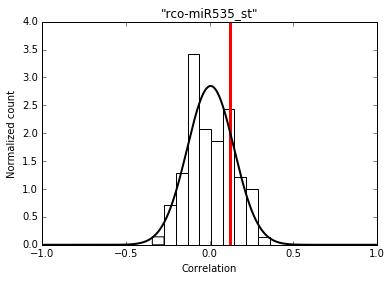

In [8]:
from scipy.stats import norm
# show results only for these genes
idx_genes_to_show = [12,1181,8590,5592, 2345,17836] 

# plot: loop over idx_genes_to_show
for idx in idx_genes_to_show: 
    fig = plt.figure()
    random_correlations = corr_random[idx,:]
    plt.hist(random_correlations,normed=True,color='w') # histogramme des valeurs de corrélation obtenues à partir des données randomisées
    plt.vlines(corr[idx],0,4,'r',lw=3) # valeur observée = ligne verticale rouge
    plt.title(data[idx+1,0]) # nom du gène
    plt.xlim([-1,1])
    plt.ylim([0, 4])
    plt.xlabel('Correlation')
    plt.ylabel('Normalized count')
    
    # fit gaussian to distribution of correlations from randomized data
    xx = np.linspace(-1,1,500)
    mu = np.mean(random_correlations)
    sigma = np.std(random_correlations)
    plt.plot(xx,norm.pdf(xx,loc=mu,scale=sigma),'k-',lw=2)

On peut constater que pour certains gènes, (inversemment) corrélés dans le set de données originales, il n'y a pas de corrélation dans les données randomisées 200 fois. On peut donc assumer que ces corrélations ne sont pas seulement des données chanceuses.

Ci-dessous nous calculons la *p-value* de chaque corrélation, afin de connaître la probabilité que la corrélation soit issue de la même distribution que les données aléatoire.

In [9]:
N_genes = np.shape(data)[0]-1 # number of genes in the data

pval_correl = [] # p-values 
for idx in range(0,N_genes):
    
    # random correlation: calculate mean and standard deviation
    random_correlations = corr_random[idx,:]
    mean_random = np.mean(random_correlations)
    std_random = np.std(random_correlations)
    
    # observed correlation
    observed_correlation = corr[idx]
    
    # cdf: cumulative distribution function = integral of the gaussian distribution from -inf to observed_correlation
    cdf = norm.cdf(observed_correlation,loc=mean_random,scale=std_random)
    
    if cdf >= 0.5:
        p = 1 - cdf
    else:
        p = cdf
    pval_correl.append(2*p) # factor 2 because correlations can take both positive and negative values
    
    # show p-value visually for the first gene (p-value = area of black hatched regions under the curve)
    #if idx==12 or idx==1181 or idx==17836:
    if idx==-1 :
        print('Observed Correlation for gene ', idx, ' Named: ', data[idx+1,1] ,' : ', observed_correlation)
        print('Mean Random: ', mean_random)
        plt.figure()
        plt.plot(xx,norm.pdf(xx,loc=mean_random,scale=std_random),'k-',lw=2)
        plt.vlines(corr[idx],0,4 ,'r',lw=2)
        for j in np.linspace(observed_correlation,1,100*(1-observed_correlation)):
            plt.vlines(j,0,norm.pdf(j,loc=mean_random,scale=std_random),'k',lw=1)
        for j in np.linspace(-1,-observed_correlation,100*(1-observed_correlation)):
            plt.vlines(j,0,norm.pdf(j,loc=mean_random,scale=std_random),'k',lw=1)
        plt.xlabel('Correlation')
        plt.ylabel('Normalized count')
        plt.show()

In [10]:
import stats

('fdr_pval: ', 7.0746723075723561e-06)
-log10(p-value FDR) = 5.15029367147



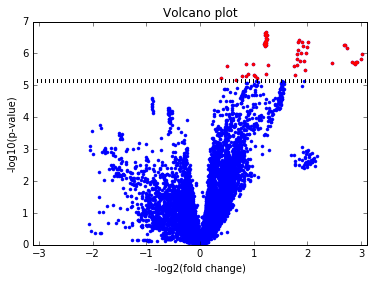

61 significant genes found with correlation (after p-value correction): 
['"bta-miR-187_st"' '"bta-miR-221_st"' '"bta-miR-224_st"'
 '"cfa-miR-187_st"' '"cfa-miR-221_st"' '"cfa-miR-224_st"'
 '"cfa-miR-421_st"' '"dan-miR-100_st"' '"dmo-miR-100_st"'
 '"dre-miR-187_st"' '"dre-miR-221_st"' '"dre-miR-222b_st"'
 '"dya-miR-100_st"' '"eca-miR-187_st"' '"eca-miR-221_st"'
 '"eca-miR-224_st"' '"eca-miR-301a_st"' '"fru-miR-187_st"'
 '"fru-miR-221_st"' '"gga-miR-187_st"' '"gga-miR-221_st"'
 '"ggo-miR-187_st"' '"ggo-miR-221_st"' '"ggo-miR-224_st"'
 '"hsa-miR-187_st"' '"hsa-miR-221_st"' '"hsa-miR-224_st"'
 '"hsa-miR-362-3p_st"' '"hvt-miR-H14-star_st"' '"mdo-miR-100_st"'
 '"mdo-miR-187_st"' '"mdo-miR-221_st"' '"mml-miR-187_st"'
 '"mml-miR-221_st"' '"mml-miR-224_st"' '"mmu-miR-187_st"'
 '"mmu-miR-221_st"' '"mmu-miR-24-1-star_st"' '"mne-miR-187_st"'
 '"mne-miR-224_st"' '"oan-miR-187_st"' '"oan-miR-221_st"'
 '"ppa-miR-187_st"' '"ppa-miR-221_st"' '"ppa-miR-224_st"'
 '"ppy-miR-187_st"' '"ppy-miR-221_st"' '"

In [11]:
# Multiple-testing-corrected p-value
fdr_pval = stats.fdr_correction(pval_correl, 0.025)
print("fdr_pval: ", fdr_pval)
print('-log10(p-value FDR) = '+str(-np.log10(fdr_pval))+'\n')

# idx of genes with p-value < fdr_pval
idx_sg_corr = np.array([i for i,p in enumerate(pval_correl) if p<fdr_pval])

# Volcano plot that shows significant genes in red
stats.volcano_plot(data[1:,1:],desired_profile,pval=pval_correl,idx=idx_sg_corr)

# print name of most significant genes
print(str(len(idx_sg_corr))+' significant genes found with correlation (after p-value correction): \n'+str(data[idx_sg_corr+1,0]))

Nous pouvons constater que 179 gènes ont une *p-valeur* suffisamment petite pour être pris en compte.

Ci-dessous nous affichons une *heatmap* afin de visualiser l'expression de ces gènes selons les le type de cellule (cancéreuse ou normal).

['"1367452_st"' '"1367453_st"' '"1367454_st"' ..., '"zma-miR529_st"'
 '"zma-miR827-star_st"' '"zma-miR827_st"']


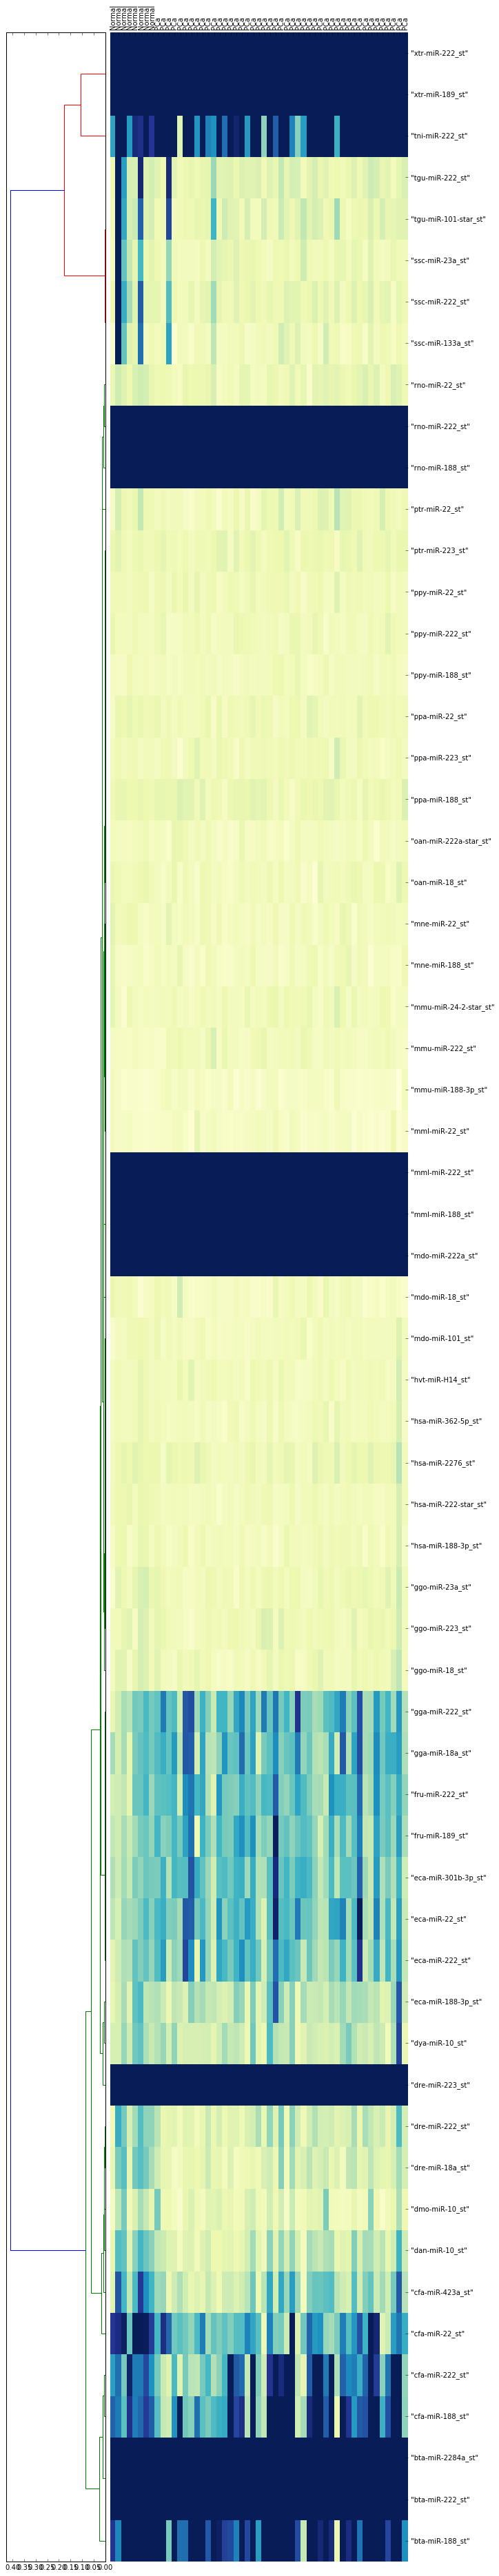

In [12]:
def show_matrix_expression(data,idx_genes,id_cond,dim=(16,10),show_ylabels=True):
    
    # data: matrix of data with headers
    # idx_genes: idx of genes 
    
    import matplotlib
    import scipy.cluster.hierarchy as cl
    import scipy.spatial.distance as ssd
    
    if isinstance(idx_genes,list):
        idx_genes = np.array(idx_genes,dtype=int)
    
    conditions = data[0,1:]
    genes = data[1:,0]
    print(genes)
    data_to_show = data[idx_genes,1:]
    
    # re-order genes using hierarchical clustering
    fig = plt.figure(num=None,figsize=(dim),dpi=250) 
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
    dmat = ssd.pdist(data_to_show,'cosine')
    Z = cl.linkage(ssd.squareform(dmat),method='average',metric='cosine')
    Z = cl.dendrogram(Z,orientation='left',no_labels=True)
    idx_reorder = Z['leaves']
    data_to_show = data_to_show[idx_reorder,:]    
    
    # plot heatmap
    ax = fig.add_axes([0.3,0.1,0.6,0.6])
    heatmap = ax.pcolor(data_to_show, cmap=plt.cm.YlGnBu,vmin=5,vmax=110)
    
    ## pour faire joli...............................................................................
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data_to_show.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(data_to_show.shape[0])+0.5, minor=False)

    # frame and labels position...
    ax.set_frame_on(False)
    ax.xaxis.tick_top()
    ax.grid(False)
    plt.xlim([0,np.shape(data_to_show)[1]])
    plt.ylim([0,np.shape(data_to_show)[0]])

    # set xlabels and ylabels
    if show_ylabels:
        ax.set_yticklabels([genes[ii+1] for ii in idx_genes], minor=False) 
    else:
        ax.yaxis.tick_right()
        ax.set_yticklabels([genes[ii+1] for ii in idx_genes])
    #conditions = [id_cond[s] for s in conditions]
    ax.set_xticklabels(conditions, minor=False)

    # rotate tick labels and set size
    plt.xticks(rotation=90) # rotate xlabels
    matplotlib.rcParams['xtick.labelsize'] = 10
    
    plt.show()

show_matrix_expression(data,idx_sg_corr,data[0,1:],dim=(10,85),show_ylabels=False)

Nous vérifions que les p-valeurs empiriques qu nous avont calculées et celles retournées par pearson_genes() sont bien similaires.

(0, 1)

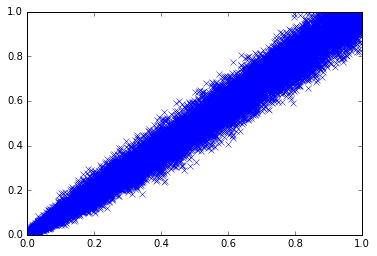

In [13]:
plt.figure()
plt.plot(co[1],pval_correl,'bx')
plt.xlim([0,1])
plt.ylim([0,1])

In [14]:
# t-test
################
# C'est la que ça merde surement !!
print list(enumerate(data[0,1:]))
print("----------------------------")
print(data[0])
print("----------------------------")


from scipy.stats import ttest_ind

N_genes = np.shape(data)[0]-1 # number of genes 
idx_PCa = [i for i,c in enumerate(data[0,1:]) if data[0,i]=='PCa'] # column idx with leukemia
print("idx PCa: ",idx_PCa)
cell_type = ['Normal','PCa']

# perform t-test between cancer cell type and normal cell type
pval_ct = [] # p-value across cell types
for k,ct in enumerate(cell_type[:-1]):  
    print("k: ", k)
    print("ct; ", ct)
    
    idx_normal = [i for i,c in enumerate(data[0,1:]) if data[0,i]==ct] # column idx corresponding to a cell type
    print(idx_normal)
    pval = []
    for g in range(1,N_genes+1): # loop over genes
    
        normal = np.array(data[g,idx_normal],dtype=float)
        PCa = np.array(data[g,idx_PCa],dtype=float)
        ttest = ttest_ind(PCa,normal,equal_var=True) # return t-value and its associated p-value
        #equal_var : bool, optional If True (default), perform a standard independent 2 sample test 
        #that assumes equal population variances [R315]. 
        #If False, perform Welch’s t-test, which does not assume equal population variance [R316].
        pval.append(ttest[1])
    pval_ct.append(pval)
print np.shape(pval_ct)


[(0, 'Normal'), (1, 'Normal'), (2, 'Normal'), (3, 'Normal'), (4, 'Normal'), (5, 'Normal'), (6, 'Normal'), (7, 'Normal'), (8, 'PCa'), (9, 'PCa'), (10, 'PCa'), (11, 'PCa'), (12, 'PCa'), (13, 'PCa'), (14, 'PCa'), (15, 'PCa'), (16, 'PCa'), (17, 'PCa'), (18, 'PCa'), (19, 'PCa'), (20, 'PCa'), (21, 'PCa'), (22, 'PCa'), (23, 'PCa'), (24, 'PCa'), (25, 'PCa'), (26, 'PCa'), (27, 'PCa'), (28, 'PCa'), (29, 'PCa'), (30, 'PCa'), (31, 'PCa'), (32, 'PCa'), (33, 'PCa'), (34, 'PCa'), (35, 'PCa'), (36, 'PCa'), (37, 'PCa'), (38, 'PCa'), (39, 'PCa'), (40, 'PCa'), (41, 'PCa'), (42, 'PCa'), (43, 'PCa'), (44, 'PCa'), (45, 'PCa'), (46, 'PCa'), (47, 'PCa'), (48, 'PCa'), (49, 'PCa'), (50, 'PCa'), (51, 'PCa'), (52, 'PCa')]
----------------------------
['"ID_REF"' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa'
 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa'
 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 'PCa' 

In [15]:
# fdr correction
reload(stats)
fdr_pval = [stats.fdr_correction(pval_ct[ct],0.025) for ct in range(len(pval_ct))]

#print("fdr_pval: ", fdr_pval)

# keep genes for which the t-test p-value is smaller than the fdr-corrected threshold (fdr_pval)
idx_sg_ttest = []
for i in range(N_genes):
    significant = [1 if pval_ct[ct][i]<fdr_pval[ct] else 0 for ct in range(len(pval_ct))]
    # On compare avec 1 condition (PCa vs Normal)
    if sum(significant)==1:
        idx_sg_ttest.append(i)

# keep only genes that appear significantly in each t-test AND in the correlation test

# Vérification s'il y a des gènes en commun entre les deux méthodes

idx_sg_ttest = np.array(idx_sg_ttest)

print("nb gene from correlation: ", len(idx_sg_corr))
print ("idx_sg_corr: ", idx_sg_corr)

print("nb gene from ttest: ", len(idx_sg_ttest))
print("idx_sg_ttest: ", idx_sg_ttest  )

# Le t-test n'est pas très utile ici car tous les gènes qu'il sélectionne sont déjà partie du test de Pearson. 

idx_sg_final = np.array( list( set(idx_sg_ttest) & set(idx_sg_corr) ) )

idx_sg_final.sort()
print("Nb final genes: ", len(idx_sg_final))
print("idx_sg_final: ", idx_sg_final)



('nb gene from correlation: ', 61)
('idx_sg_corr: ', array([ 2126,  2182,  2185,  3139,  3185,  3188,  3264,  4363,  4776,
        5321,  5390,  5392,  5882,  6103,  6155,  6158,  6174,  8082,
        8112,  8555,  8600,  8720,  8742,  8744, 11557, 11664, 11670,
       11881, 12458, 12733, 12789, 12820, 13058, 13108, 13111, 13599,
       13751, 13758, 14213, 14232, 15145, 15203, 15920, 15941, 15943,
       16525, 16582, 16585, 17428, 17430, 17973, 18025, 18028, 19090,
       19150, 19152, 19359, 19461, 19639, 20218, 20260]))
('nb gene from ttest: ', 237)
('idx_sg_ttest: ', array([  377,   739,   803,   888,  1253,  1263,  1386,  2064,  2065,
        2126,  2150,  2153,  2182,  2183,  2185,  2462,  2468,  2488,
        2624,  3087,  3113,  3139,  3160,  3185,  3186,  3188,  3197,
        3264,  3885,  4191,  4233,  4363,  4369,  4440,  4446,  4518,
        4524,  4602,  4776,  4782,  4853,  4930,  5189,  5193,  5272,
        5297,  5315,  5321,  5390,  5392,  5403,  5415,  5482,  5488,


On a maintenant 217 miARN sélectionnée qui sont le résultat de la concaténation des meilleurs miARN séléctionnés par les méthode de la corrélation et du t-test. 

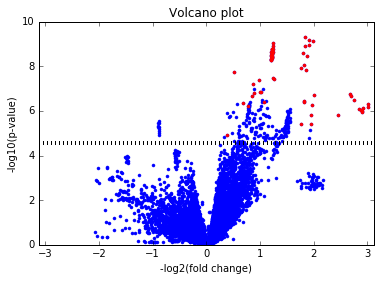

In [16]:
stats.volcano_plot(data[1:,1:],desired_profile,idx=idx_sg_corr)

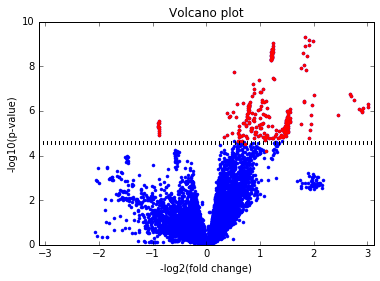

In [17]:
stats.volcano_plot(data[1:,1:],desired_profile,idx=idx_sg_ttest)

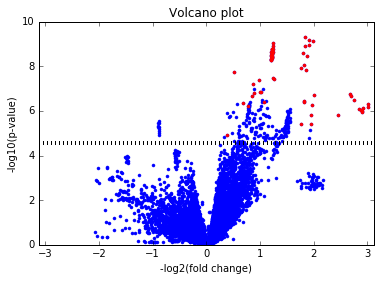

('nombre de micro-ARN pris en compte: ', '61')


In [18]:
stats.volcano_plot(data[1:,1:],desired_profile,idx=idx_sg_final)
print("nombre de micro-ARN pris en compte: ", str(len(idx_sg_final)))

## Construction d'un classificateur pour développer un outil diagnostique

In [27]:
X = data[idx_sg_final,1:]
# il faut transposer la matrice, car SVM s'attend a recevoir les features en colonnes et non en lignes
X = np.transpose(X) 
#print(X)
#y = [1 if id_cond[s]=='AML' else 0 for s in data[0,1:]]
y = desired_profile
#print(y)

# test set
X_test = data_test[idx_sg_final,1:]
X_test = np.transpose(X_test)
#y_test = [1 if id_cond[s]=='AML' else 0 for s in data_test[0,:]]
y_test = desired_profile_test

In [42]:
def kNN_classifier(X,y,X_test,y_test):
    
    from sklearn import neighbors
    
    # train de SVM classifier
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X, y)

    # predict on the test set
    pred_kNN = clf.predict(X_test)
    
    # return score
    score = clf.score(X_test,y_test)
    return score

def SVM_classifier(X, y, X_test, y_test):
    
    from sklearn import svm
    
    clf = svm.SVC()
    clf.fit(X, y)
    
   
    pred_svm = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    
    return score

def RandomForest_classifier(X, y, X_test, y_test):
    
    # Import the random forest package
    from sklearn.ensemble import RandomForestClassifier 
    
    # Create the random forest object which will include all the parameters
    # for the fit
    forest = RandomForestClassifier(n_estimators = 100)

    # Fit the training data to the Survived labels and create the decision trees
    forest = forest.fit(X,y)

    # Take the same decision trees and run it on the test data
    pred_RandForest = forest.predict(X_test)
    
    score = forest.score(X_test, y_test)
    return score
    
    
    
    

score = kNN_classifier(X,y,X_test,y_test)
print(score)

score = SVM_classifier(X,y,X_test, y_test)
print(score)

score = RandomForest_classifier(X,y,X_test, y_test)
print(score)
#print('Le classificateur kNN fait '+str(round(100*score))+'% de prédictions correctes (sur le test set).')

0.857142857143
0.714285714286
0.857142857143


Le classificateur réussi à X% les prédictions avec les X miARN. 

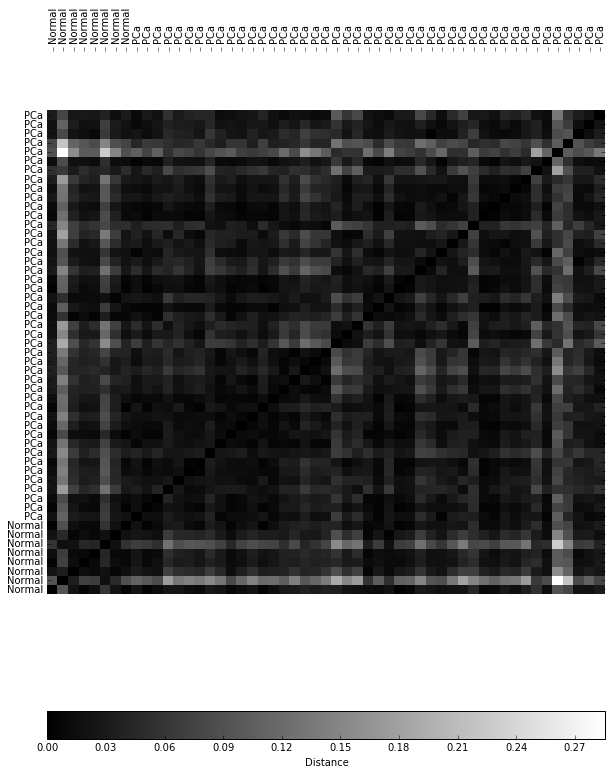

In [43]:
import scipy.spatial.distance as ssd
import matplotlib

# calculate distance between any two conditions in X
D = ssd.pdist(X,'cosine')
Ds = ssd.squareform(D)

#print("D : ", len(D), D)
#print("Ds : ", len(Ds), Ds)

# plot
fig, ax = plt.subplots(num=None,figsize=(10,14),dpi=250) 
heatmap = ax.pcolor(Ds, cmap=plt.cm.gray)

ax.set_xticks(np.arange(Ds.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(Ds.shape[0])+0.5, minor=False)

ax.set_frame_on(False)
ax.xaxis.tick_top()
ax.grid(False)
plt.xlim([0,np.shape(Ds)[1]])

labels = [cell_type[s] for s in desired_profile]
ax.set_yticklabels(labels, minor=False) 
ax.set_xticklabels(labels, minor=False)

plt.xticks(rotation=90) # rotate xlabels
matplotlib.rcParams['xtick.labelsize'] = 10

cbar = fig.colorbar(heatmap, orientation='horizontal')
cbar.set_label('Distance')

In [24]:
#print(data[0,:])
#print(data[1,:])
print("-------------------------")

#print(data[idx_sg_final,1:])



print("-------------------------")

#print(data[2126,1:])


print("-------------------------")

#print(idx_PCa)
#print(idx_normal)
#print(idx_sg_corr)
#print(idx_sg_final)
print(data)
print(data_test)

-------------------------
-------------------------
-------------------------
[['"ID_REF"' 'Normal' 'Normal' ..., 'PCa' 'PCa' 'PCa']
 ['"1367452_st"' '17.73092' '13.50618' ..., '17.9872' '16.10932' '14.50111']
 ['"1367453_st"' '15.98614' '17.80959' ..., '19.47316' '15.15539' '17.9957']
 ..., 
 ['"zma-miR529_st"' '18.99103' '13.52609' ..., '13.46852' '12.53141'
  '13.16191']
 ['"zma-miR827-star_st"' '15.40228' '14.92211' ..., '15.38391' '14.37837'
  '16.76542']
 ['"zma-miR827_st"' '17.98331' '17.41605' ..., '10.7645' '14.51185'
  '11.54497']]
[['"ID_REF"' 'Normal' 'Normal' ..., 'PCa' 'PCa' 'PCa']
 ['"1367452_st"' '11.47406' '13.86868' ..., '11.64925' '14.36717'
  '15.29177\n']
 ['"1367453_st"' '14.39909' '16.66849' ..., '15.40274' '21.7944'
  '25.17342\n']
 ..., 
 ['"zma-miR529_st"' '15.43849' '17.41694' ..., '14.28834' '14.30447'
  '13.03476\n']
 ['"zma-miR827-star_st"' '13.1045' '13.57387' ..., '8.361436' '9.77377'
  '16.02319\n']
 ['"zma-miR827_st"' '16.66401' '14.32412' ..., '13.189